In [1]:
 !nvidia-smi -L
 

GPU 0: Tesla T4 (UUID: GPU-e5e04cff-ad3c-a937-60ef-f2bd7c717676)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [4]:
!ls pubmed-rct
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md
dev.txt  test.txt  train.txt


In [5]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# function to read lines of a document, and returns lines of text as list

def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir +"train.txt")

In [8]:
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line 
      abstract_lines = ""
    elif line.isspace(): #True if the line is \n
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split)
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples



In [10]:
train = preprocess_text_with_line_numbers(data_dir + "train.txt")
val = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test = preprocess_text_with_line_numbers(data_dir + "test.txt")


In [11]:
import pandas as pd
train_df=pd.DataFrame(train)
val_df = pd.DataFrame(val)
test_df = pd.DataFrame(test)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


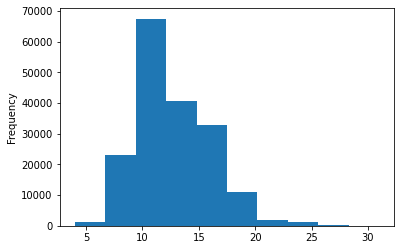

In [12]:
train_df.total_lines.plot.hist()

In [13]:
train_sentences = train_df["text"].tolist()
test_sentences = test_df["text"].tolist()
val_sentences = val_df["text"].tolist()

LABEL PREPROCESSING, CHANGING IT TO ONE HOT ENCODED ARRAY OR LABEL ENCODED

In [14]:
# labels to numbers
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_onehot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_onehot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_onehot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))


In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

classes = label_encoder.classes_
classes

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [16]:
#average length of a sentences
np.mean([len(sentence.split())for sentence in train_sentences])

26.338269273494777

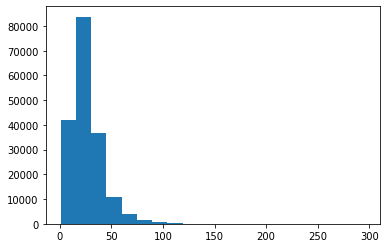

In [17]:

plt.hist([len(sentence.split())for sentence in train_sentences], bins=20);

In [18]:
#Top 95 percentile sentence of length is 55 words long
np.percentile([len(sentence.split())for sentence in train_sentences],95)

55.0

In [19]:
#TOKEN VECTORIZATION
max_tokens = 68000
output_seq_len =55
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length = output_seq_len)

In [20]:
text_vectorizer.adapt(train_sentences)

In [21]:
#TOKEN EMBEDDING
token_embed = layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                               output_dim=128,
                               mask_zero =True,
                               name ="token_embedding")

Characters pre-preprocessing


In [24]:
#creating character level splits
def split_chars(text):
  return " ".join(list(text))
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
mean_chars_len=149
output_seq_char_len = 290

In [25]:
import string
alphabet = string.ascii_lowercase+ string.digits+string.punctuation

In [26]:
## CHARACTER VECTORIZATION
NUM_CHAR_TOKENS = len(alphabet) + 2 
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")


char_vectorizer.adapt(train_chars)

In [27]:
#CHARACTER EMBEDDING
char_embed = layers.Embedding(input_dim = len(char_vectorizer.get_vocabulary()),
                              output_dim= 25,
                              mask_zero = True,
                              name = "char_embed")


In [29]:
## create an embedding layer from tensorflow hub
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

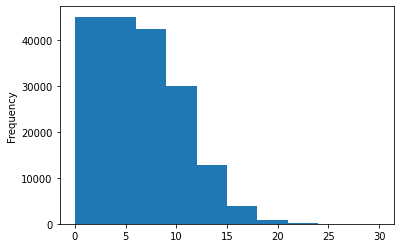

In [30]:
train_df.line_number.plot.hist()

In [31]:
# one hot encode the line number, since most of them are 15 lines long, we will go with 15
train_line_numbers_onehot = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_line_numbers_onehot = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_line_numbers_onehot = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)

In [32]:
#same idea but for total_lines
train_total_lines_onehot = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_total_lines_onehot = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_total_lines_onehot = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)

In [33]:
## after creating character and words embeddings, time to build multi-modal model (hybrid embedding model)

# 1-token (words) inputs
token_inputs = layers.Input(shape =[], #hub layer
                            dtype= tf.string, name ="input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output= layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2-char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

## 3-concatenate 1, 2
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])
token_char_concat_output = layers.Dense(256, activation="relu")(token_char_concat)
token_char_concat_output = layers.Dropout(0.5)(token_char_concat_output)

## 4-create model for line_number
line_number_input = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
line_number_output = layers.Dense(32,activation="relu")(line_number_input)
line_number_model = tf.keras.Model(inputs=line_number_input,
                                   outputs=line_number_output)
## 5-create model for total lines
total_lines_input = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
total_lines_output = layers.Dense(32,activation="relu")(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                   outputs=total_lines_output)

## 6-concatenate 3,4,5
char_token_lines_concat = layers.Concatenate(name="char_token_lines_concat")([line_number_model.output, 
                                                                              total_lines_model.output,
                                                                              token_char_concat_output #didnt use .output because its not a model
                                                                              ])


## 7-create the output layers
output_layer = layers.Dense(len(classes), activation ="softmax", name="output_layer")(char_token_lines_concat)

model = tf.keras.Model(inputs =[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
                       outputs = output_layer,
                       name="model")


In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
input (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   input[0][0]                      
______________________________________________________________________________________________

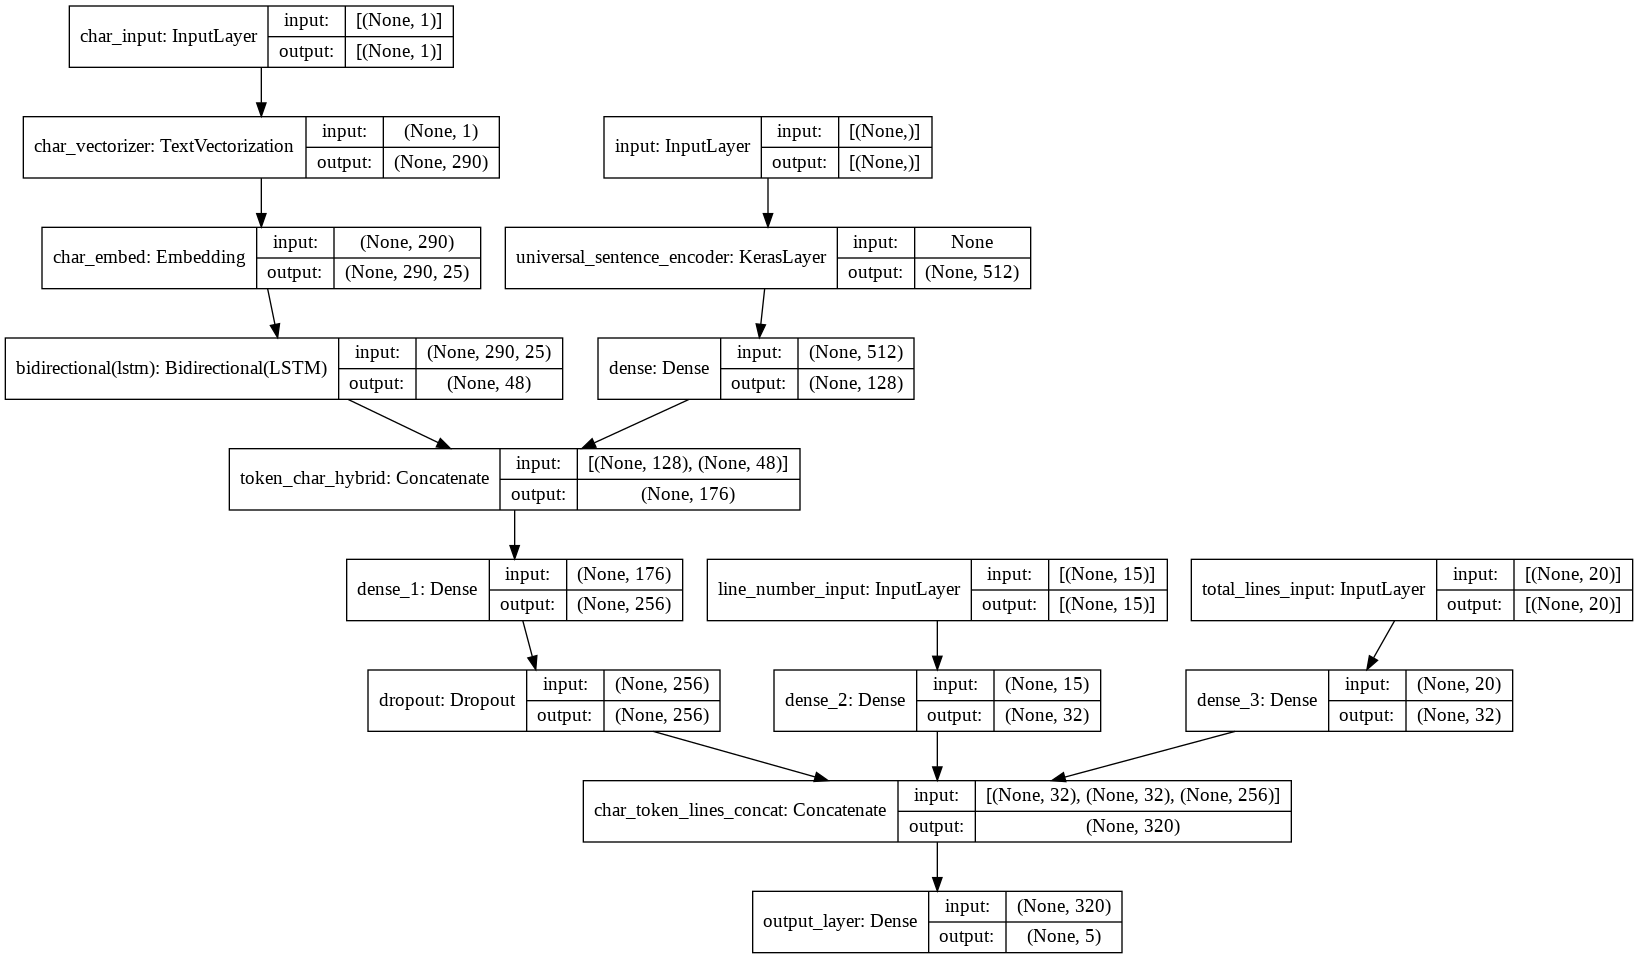

In [35]:
## plot the model
from tensorflow.keras.utils import plot_model
plot_model(model , show_shapes=True)

In [36]:
model.compile(loss =tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer="adam",
              metrics =["accuracy"])

In [37]:
# combine chars, tokens, and numbers as an input 
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_onehot, # line numbers
                                                                train_total_lines_onehot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_onehot,
                                                              val_total_lines_onehot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [38]:
model_history = model.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 51ms/step - loss: 1.0961 - accuracy: 0.7236 - val_loss: 0.9849 - val_accuracy: 0.8065
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.9688 - accuracy: 0.8136 - val_loss: 0.9525 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9508 - accuracy: 0.8237 - val_loss: 0.9401 - val_accuracy: 0.8305


In [39]:
model.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.9377 - accuracy: 0.8309


[0.9377061128616333, 0.8308950066566467]

In [40]:
model_pred_probs = model.predict(val_pos_char_token_dataset)

In [41]:
model_preds = tf.argmax(model_pred_probs, axis =1)

In [42]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true, y_pred):
	""""
	EVALUATE ACCURACY, PRECISION, RECALL, F1 SCORE
	"""
	model_accuracy = accuracy_score(y_true, y_pred) * 100
	model_precision, model_recall, model_f1,_ = precision_recall_fscore_support(y_true, y_pred,average="weighted")
	model_results = {"accuracy":model_accuracy,
					 "precision":model_precision,
					 "recall" :model_recall, 
					 "f1":model_f1}
	return model_results


In [43]:
calculate_results(y_true= val_labels_encoded, #label array outputted from the label encoder of sklearn
                  y_pred=model_preds)

{'accuracy': 83.08950086058519,
 'f1': 0.8293630189440715,
 'precision': 0.8307249525524745,
 'recall': 0.830895008605852}